In [2]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

load data

In [76]:
merged_df = pd.read_csv('data/main/merged_data.csv')

In [310]:
#merged_df = merged_df[merged_df['industry_1'] == 'Erbringung von sonstigen wirtschaftlichen Dienstleistungen']

In [324]:
merged_df = merged_df[merged_df['size'] == 'Kleine und mittlere Unternehmen']

In [ ]:
list(merged_df.columns)

In [325]:
ratios = ['current_ratio','qick_ratio','cash_ratio','debt2equity_ratio','debt2asset_ratio','equity_ratio']
types = ['grant','loan']
results_dict = {}

In [326]:
for year in [2020,2021]:

    for id, type in enumerate(types, start=1):
        type_inverse_year = types[id-2] + '_' + str(year)
        type_year = type + '_' + str(year)
        data_unconfounded = merged_df[merged_df[type_inverse_year].isnull()]

        if year == 2021: # Remove companies that received other aid due to possible confounding
                data_unconfounded = data_unconfounded[data_unconfounded[('grant'+'_'+ str(year-1))].isnull()] ###
                data_unconfounded = data_unconfounded[data_unconfounded[('loan'+'_'+ str(year-1))].isnull()] ###
        
        results = {}
        

        for ratio in ratios:
            

            ratio_year_prior = ratio + '_' + str(year-1)
            ratio_year = ratio + '_' + str(year)

            data_dd = data_unconfounded[[ratio_year_prior , ratio_year, type_year]]
            data_dd['treatment_group'] = np.where(data_dd[type_year].isna() , 0, 1)
            data_dd = data_dd.drop(type_year, axis=1)
            data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
            data_dd = data_dd.dropna()

            # data before the treatment
            df_before = data_dd[[ratio_year_prior, 'treatment_group']]
            df_before['t'] = 0
            df_before.columns = [ratio, 'treatment_group', 'time']

            # data after the treatment
            df_after = data_dd[[ratio_year, 'treatment_group']]
            df_after['t'] = 1
            df_after.columns = [ratio, 'treatment_group', 'time']

            # data for regression
            df_reg = pd.concat([df_before, df_after])

            # create the interaction 
            df_reg['interaction'] = df_reg.treatment_group * df_reg.time

            # drop extrem outliers
            df_reg = df_reg[df_reg[ratio] > 0 ]
            df_reg = df_reg.drop(df_reg[df_reg[ratio] > df_reg[ratio].quantile(.95)].index)
            

            from statsmodels.formula.api import ols
            formular = ratio + ' ~ treatment_group + time + interaction' 
            #print(formular)
            ols = ols(formular, data=df_reg).fit()
            
            #print(year,type,ratio)
            #print(ols.params['interaction'].round(4) , ols.pvalues['interaction'].round(3))
            #print(ols.summary())

            results[ratio] = ols.params['interaction'].round(4) , (ols.pvalues['interaction'].round(3))
        results_dict[type_year] = results

### 

## Model

In [77]:
import os
import warnings; warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

from causal_curve import GPS_Regressor
from causal_curve import Mediation


%matplotlib inline
pd.options.mode.chained_assignment = None
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [5, 4]

In [348]:
df = pd.read_csv('data/main/merged_data.csv')

In [349]:
df = df[df['qick_ratio_2021'] < 15 ]
df = df[df['qick_ratio_2021'] > 0 ]
df = df[df['qick_ratio_2020'] < 15 ]
df = df[df['qick_ratio_2020'] > 0 ]

df = df[df['current_ratio_2021'] < 15 ]
df = df[df['current_ratio_2021'] > 0 ]
df = df[df['current_ratio_2020'] < 15 ]
df = df[df['current_ratio_2020'] > 0 ]

In [350]:
#df = df[df['industry_2'] == 'Einzelhandel (ohne Handel mit Kraftfahrzeugen)' ]
df['aid_relative_2021'] = df['grant_2021'] / df['assets_2021']

df['delta_cash_ratio_2021'] = (df['cash_ratio_2021'] - df['cash_ratio_2020'])
df['delta_cash_2021'] = (df['cash_2021'] - df['cash_2020'])
df['delta_qick_ratio_2021'] = (df['qick_ratio_2021'] - df['qick_ratio_2020'])
df['delta_current_ratio_2021'] = (df['current_ratio_2021'] - df['current_ratio_2020'])
df['delta_equity_ratio_2021'] = (df['equity_ratio_2021'] - df['equity_ratio_2020'])

#df = df[df['delta_qick_ratio_2021'] < 5 ]
#df = df[df['delta_qick_ratio_2021'] > -5 ]
#df = df[df['delta_current_ratio_2021'] < 5 ]
#df = df[df['delta_current_ratio_2021'] > -5 ]

In [351]:
condounders = pd.get_dummies(df["industry_1"], prefix='industry', drop_first=True)
condounders.columns = condounders.columns.str.replace(' ', '_')
#condounders = pd.get_dummies(df["size"], prefix='size', drop_first=True)
#condounders.columns = condounders.columns.str.replace(' ', '_')
#list(condounders.columns)

In [352]:
df = df[['delta_cash_ratio_2021',
    'delta_qick_ratio_2021',
    'delta_current_ratio_2021',
    'delta_equity_ratio_2021',
    'debt2asset_ratio_2020',
    'cash_ratio_2020',     
    'industry_1',
    'delta_cash_2021',
    'grant_2021',
    'aid_relative_2021']]
final_df = pd.concat([df,pd.get_dummies(df["industry_1"], prefix='industry', drop_first=True)],axis = 1)
final_df.columns = final_df.columns.str.replace(' ', '_')
#final_df = pd.concat([df,pd.get_dummies(df["size"], prefix='size', drop_first=True)],axis = 1)
#final_df.columns = final_df.columns.str.replace(' ', '_')

final_df


from causal_curve import TMLE_Regressor

final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
final_df = final_df.dropna()

final_df = final_df[final_df['grant_2021'].between(*final_df['grant_2021'].quantile([0.00, 0.75]).tolist())]
final_df = final_df[final_df['delta_cash_2021'].between(*final_df['delta_cash_2021'].quantile([0.05, 0.95]).tolist())]
final_df = final_df[final_df['aid_relative_2021'].between(*final_df['aid_relative_2021'].quantile([0.0, 0.95]).tolist())]
final_df = final_df[final_df['delta_cash_ratio_2021'].between(*final_df['delta_cash_ratio_2021'].quantile([0.5, 0.95]).tolist())]
#final_df = final_df[final_df['aid_relative_2021'] < final_df['aid_relative_2021'].quantile(.75, interpolation='midpoint')]
#final_df = final_df[final_df['delta_cash_2021'] < final_df['delta_cash_2021'].quantile(.75, interpolation='midpoint')]
#final_df

In [15]:
# Dictionary to store model results
results_dict = {}

# Potential confounders
potential_confounders = list(condounders.columns)

# Try the cash_ratio model
cash_ratio_tmle = TMLE_Regressor(random_seed=111,bandwidth=10)

cash_ratio_tmle.fit(
    T=final_df['aid_relative_2021'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_cash_ratio_2021']
)

results_dict['delta_cash_ratio_2021'] = cash_ratio_tmle.calculate_CDRC()

# Try the qick_ratio model
qick_ratio_tmle = TMLE_Regressor(random_seed=111,bandwidth=10)

qick_ratio_tmle.fit(
    T=final_df['aid_relative_2021'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_qick_ratio_2021']
)

results_dict['delta_qick_ratio_2021'] = qick_ratio_tmle.calculate_CDRC()

# Try the current_ratio model
current_ratio_tmle = TMLE_Regressor(random_seed=111,bandwidth=10)

current_ratio_tmle.fit(
    T=final_df['aid_relative_2021'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_current_ratio_2021']
)

results_dict['delta_current_ratio_2021'] = current_ratio_tmle.calculate_CDRC()

# Try the equity_ratio model
equity_ratio_tmle = TMLE_Regressor(random_seed=111,bandwidth=10)

equity_ratio_tmle.fit(
    T=final_df['aid_relative_2021'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_equity_ratio_2021']
)

results_dict['delta_equity_ratio_2021'] = equity_ratio_tmle.calculate_CDRC()

In [ ]:
result_class = [['delta_cash_ratio_2021', 'delta_qick_ratio_2021'], ['delta_current_ratio_2021', 'delta_equity_ratio_2021']]

result_name = [['Cash Ratio', 'Quick Ratio'], ['Current Ratio', 'Equity Ratio']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Ratio', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Change in Ratio', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 8)
        axs[1,1].set_xlabel('Aid relative to total assets', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        #axs[i,j].set_xlim(0, 2)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Balance sheet ratios Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

In [ ]:
final_df[final_df['delta_cash_2021'].between(*final_df['delta_cash_2021'].quantile([0.01, 0.99]).tolist())]


Text(0.5, 0.98, 'Balance sheet ratios Causal Curves (with 95% CIs)')

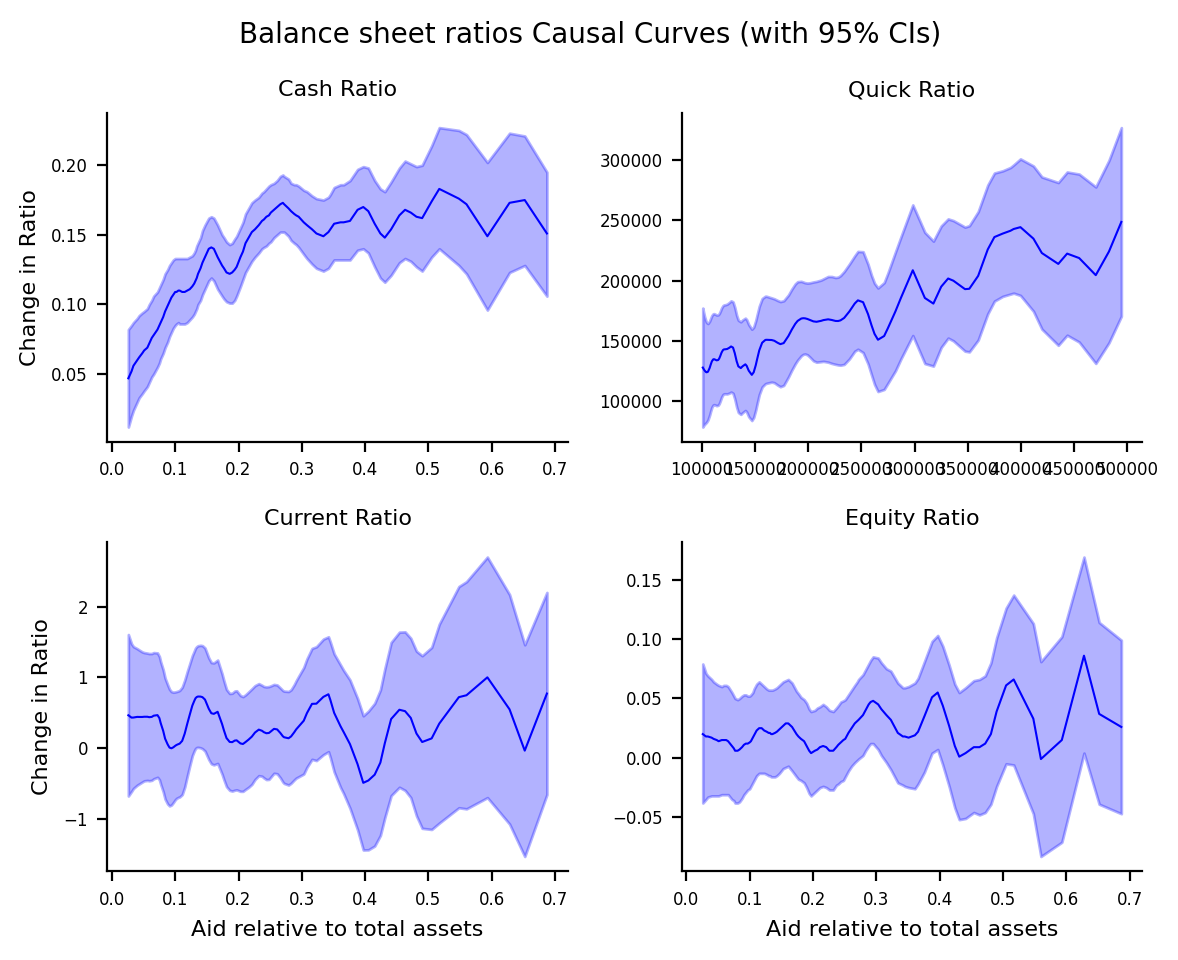

In [222]:
# Dictionary to store model results
results_dict = {}

# Potential confounders
potential_confounders = list(condounders.columns)
potential_confounders.append('debt2asset_ratio_2020')


# Try the cash_ratio model
cash_gps = GPS_Regressor(treatment_grid_num=100 ,random_seed=111)
cash_gps.fit(
    T=final_df['aid_relative_2021'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_cash_ratio_2021']
)

results_dict['delta_cash_ratio_2021'] = cash_gps.calculate_CDRC(.95)

# Try the qick_ratio model
qick_ratio_gps = GPS_Regressor(random_seed=111)
qick_ratio_gps.fit(
    T=final_df['grant_2021'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_cash_2021']
)

results_dict['delta_qick_ratio_2021'] = qick_ratio_gps.calculate_CDRC(.95)

# Try the current_ratio model
current_ratio_gps =  GPS_Regressor(random_seed=111)
current_ratio_gps.fit(
    T=final_df['aid_relative_2021'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_current_ratio_2021']
)

results_dict['delta_current_ratio_2021'] = current_ratio_gps.calculate_CDRC(.95)

# Try the equity_ratio model
equity_ratio_gps = GPS_Regressor(random_seed=111)
equity_ratio_gps.fit(
    T=final_df['aid_relative_2021'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_equity_ratio_2021']
)

results_dict['delta_equity_ratio_2021'] = equity_ratio_gps.calculate_CDRC(.95)
result_class = [['delta_cash_ratio_2021', 'delta_qick_ratio_2021'], ['delta_current_ratio_2021', 'delta_equity_ratio_2021']]
result_name = [['Cash Ratio', 'Quick Ratio'], ['Current Ratio', 'Equity Ratio']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]
fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Ratio', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Change in Ratio', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 8)
        axs[1,1].set_xlabel('Aid relative to total assets', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        #axs[i,j].set_xlim(0, 2)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Balance sheet ratios Causal Curves (with 95% CIs)", fontsize = 10)

In [23]:
results_dict['delta_cash_ratio_2021']

,Treatment,Causal_Dose_Response,Lower_CI,Upper_CI
0,0.016,0.000,-0.035,0.036
1,0.021,0.004,-0.027,0.035
2,0.027,0.007,-0.021,0.036
3,0.031,0.008,-0.018,0.033
4,0.034,0.006,-0.020,0.031
...,...,...,...,...
95,0.725,0.157,0.105,0.210
96,0.756,0.204,0.157,0.251
97,0.789,0.185,0.135,0.236
98,0.844,0.172,0.116,0.228


In [28]:
cash_gps.print_gam_summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      40.444
Link Function:                     IdentityLink Log Likelihood:                                -51991.0684
Number of Samples:                         3323 AIC:                                           104065.0248
                                                AICc:                                          104066.0972
                                                GCV:                                                0.0275
                                                Scale:                                              0.0269
                                                Pseudo R-Squared:                                    0.122
Feature Function                  Lam

In [30]:
final_df[['aid_relative_2021','delta_cash_ratio_2021']]

,aid_relative_2021,delta_cash_ratio_2021
15,0.096220,-0.137773
47,0.314365,0.143400
52,0.336925,0.047056
63,0.424700,0.243669
69,0.164803,0.037833
...,...,...
23544,0.184469,-0.057153
23545,0.443200,0.087739
23554,0.193085,-0.058617
23573,0.422494,0.282999


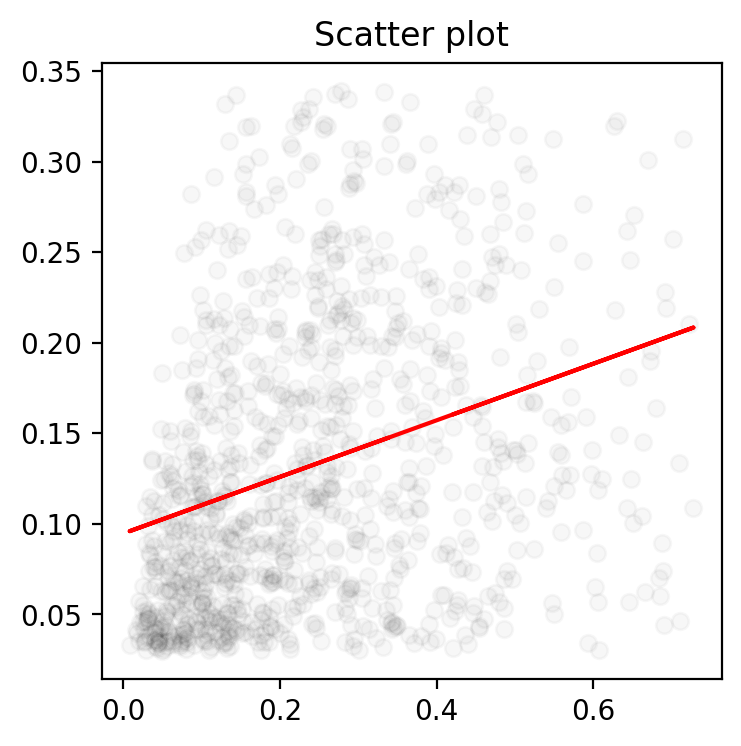

In [224]:
plt.rcParams['figure.figsize'] = (4, 4)
plt.scatter(final_df[['aid_relative_2021']],final_df[['delta_cash_ratio_2021']],  alpha=.03, color='k')
plt.title('Scatter plot')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(final_df['aid_relative_2021'],final_df['delta_cash_ratio_2021'], deg = 1)
#use red as color for regression line
plt.plot(final_df['aid_relative_2021'], m*final_df['aid_relative_2021']+b, color='red')

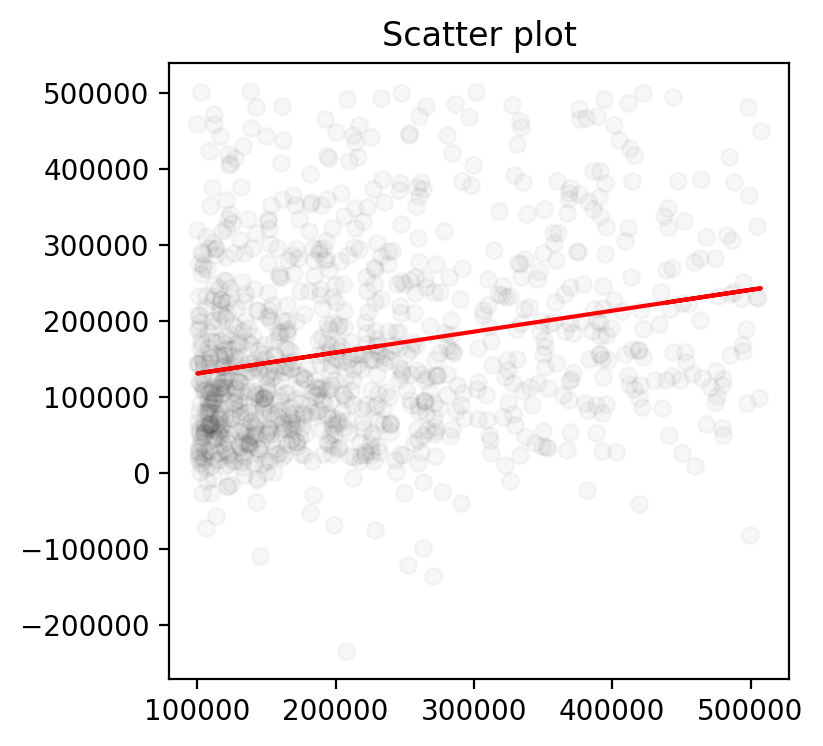

In [223]:
plt.rcParams['figure.figsize'] = (4, 4)
plt.scatter(final_df[['grant_2021']],final_df[['delta_cash_2021']],  alpha=.03, color='k')
plt.title('Scatter plot')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(final_df['grant_2021'],final_df['delta_cash_2021'], deg = 1)
#use red as color for regression line
plt.plot(final_df['grant_2021'], m*final_df['grant_2021']+b, color='red')

In [61]:
np.polyfit(final_df['aid_relative_2021'],final_df['delta_cash_ratio_2021'], 1)

array([ 0.26475814, -0.00128937])

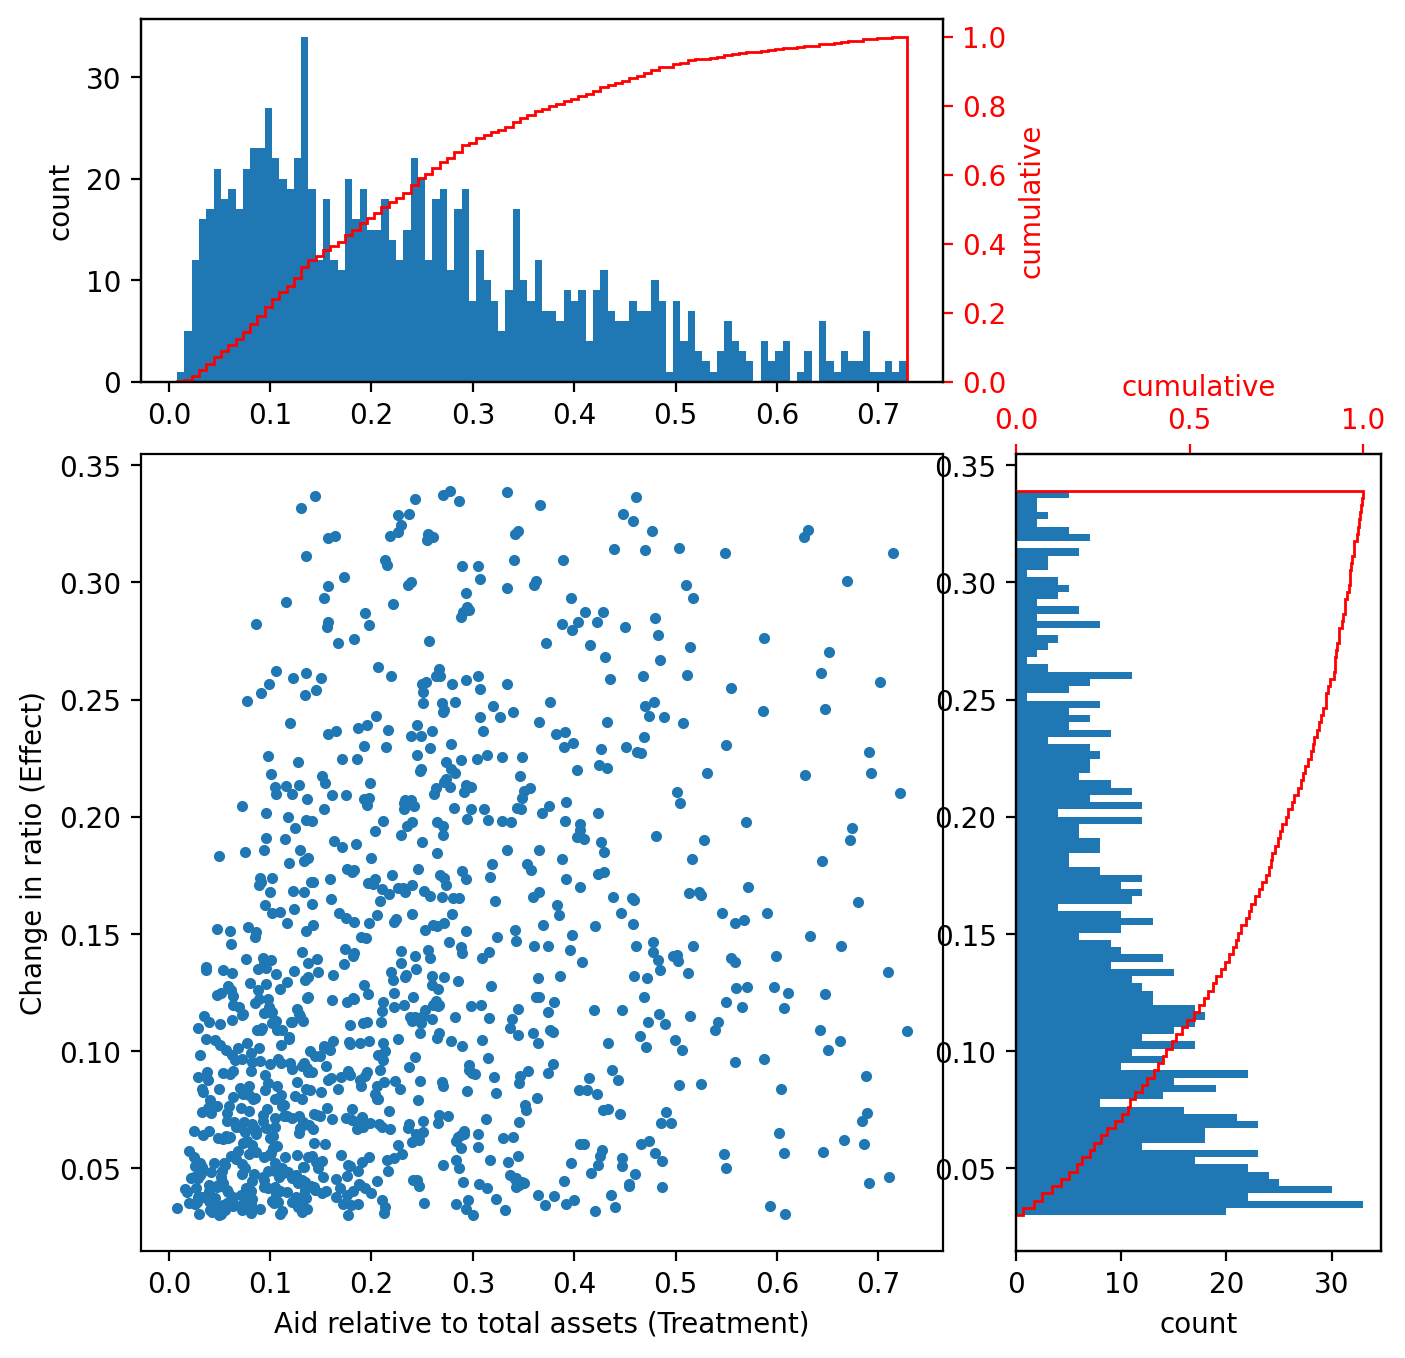

In [226]:
# https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

x = final_df[['aid_relative_2021']]
y = final_df[['delta_cash_ratio_2021']]

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
ax_main.scatter(x,y,marker='.')
ax_main.set(xlabel="Aid relative to total assets (Treatment)", ylabel="Change in ratio (Effect)")

ax_xDist.hist(x,bins=100,align='mid')
ax_xDist.set(ylabel='count')
ax_xCumDist = ax_xDist.twinx()
ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid')
ax_xCumDist.tick_params('y', colors='r')
ax_xCumDist.set_ylabel('cumulative',color='r')

ax_yDist.hist(y,bins=100,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count')
ax_yCumDist = ax_yDist.twiny()
ax_yCumDist.hist(y,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid',orientation='horizontal')
ax_yCumDist.tick_params('x', colors='r')
ax_yCumDist.set_xlabel('cumulative',color='r')

plt.show()

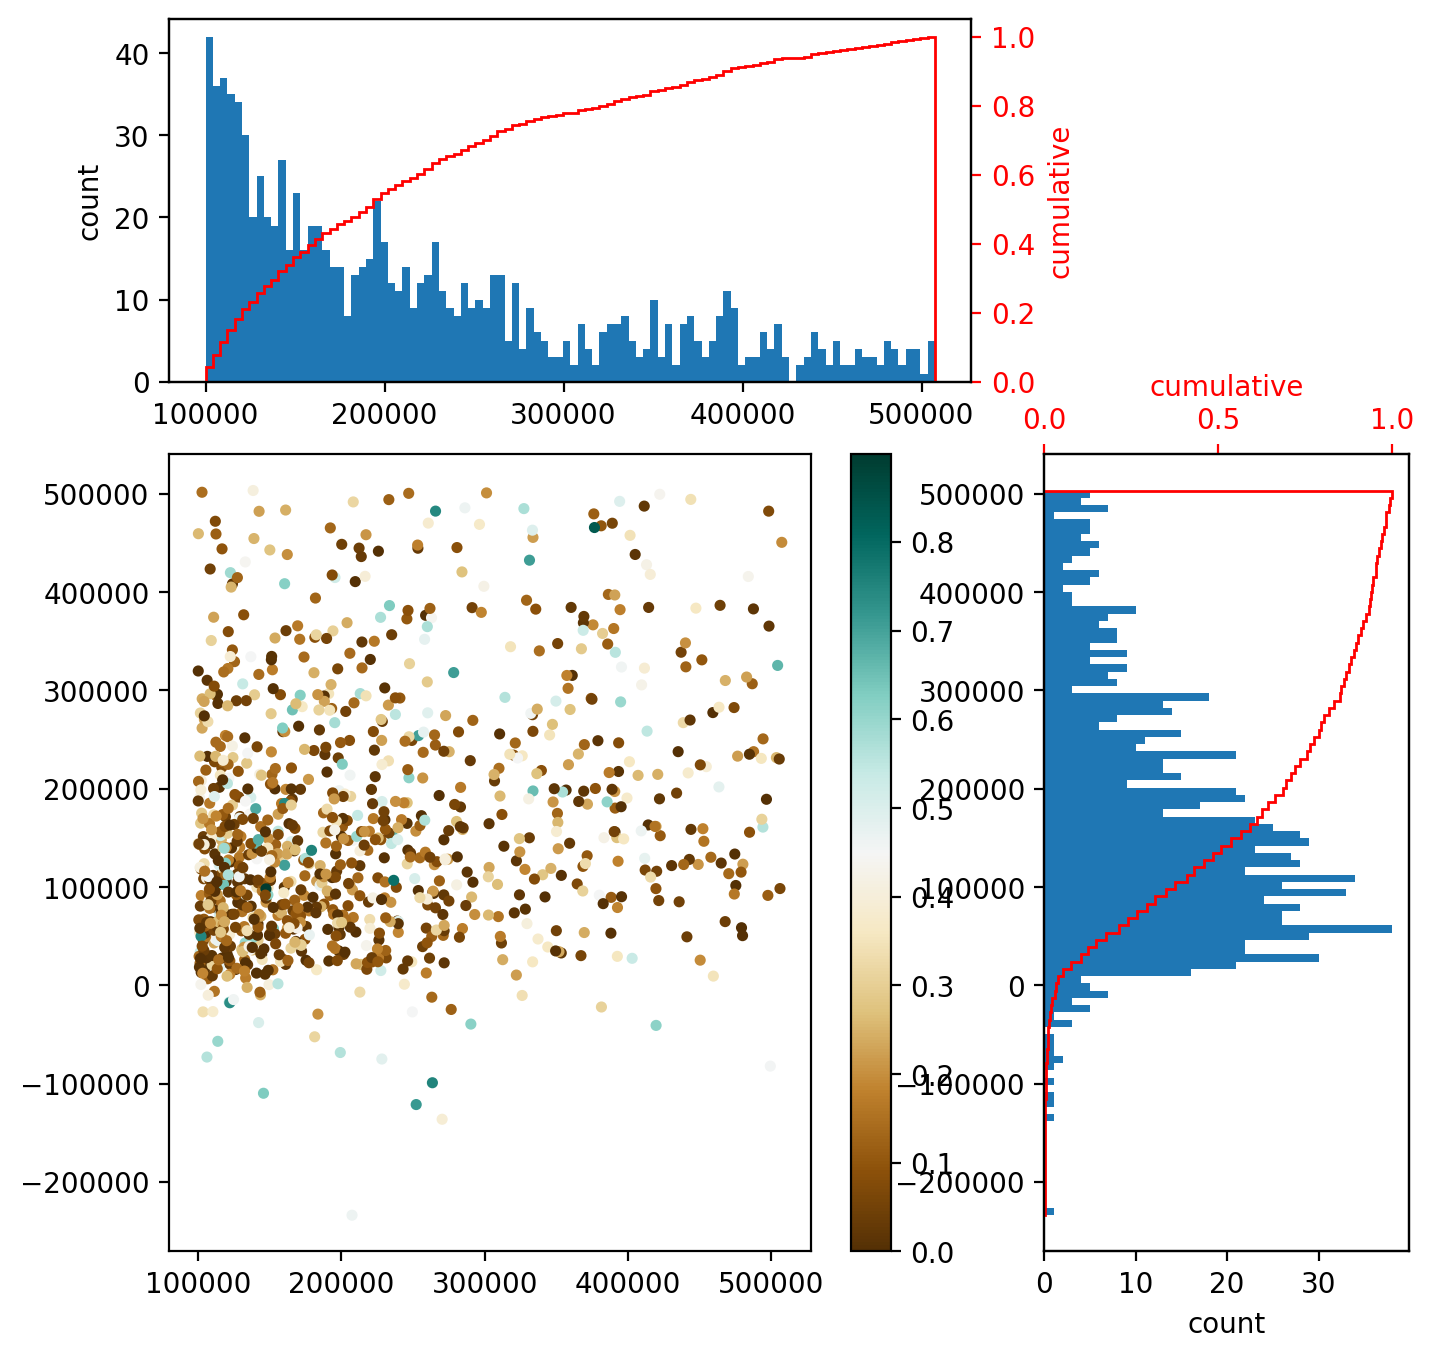

In [353]:
# https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib as mpl
import numpy as np

x = final_df[['grant_2021']]
y = final_df[['delta_cash_2021']]
z = final_df['cash_ratio_2020']

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])

#ax_bar = plt.subplot(gs[1:3, :4])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
#ax_main.scatter(x,y,c=z,marker='.',cmap="BrBG")
#ax_main.set(xlabel="Aid (Treatment)", ylabel="Change in cash (Effect)")

# colorbar
sctr = ax_main.scatter(x,y,c=z,marker='.',cmap="BrBG")
plt.colorbar(sctr, ax=ax_main)#, format='$%d')
#ax_main.set_yscale('log')


ax_xDist.hist(x,bins=100,align='mid')
ax_xDist.set(ylabel='count')
ax_xCumDist = ax_xDist.twinx()
ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid')
ax_xCumDist.tick_params('y', colors='r')
ax_xCumDist.set_ylabel('cumulative',color='r')

ax_yDist.hist(y,bins=100,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count')
ax_yCumDist = ax_yDist.twiny()
ax_yCumDist.hist(y,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid',orientation='horizontal')
ax_yCumDist.tick_params('x', colors='r')
ax_yCumDist.set_xlabel('cumulative',color='r')


plt.show()

### Diff and Diff 2020

#### 2020 grants

##### current ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['current_ratio_2019','current_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()
data_dd = data_dd.drop(data_dd[data_dd['current_ratio_2019'] > data_dd['current_ratio_2019'].quantile(.95)].index)


# data before the treatment
df_before = data_dd[['current_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['current_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['current_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['current_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['current_ratio'] > df_reg['current_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['current_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('current_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          current_ratio   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     61.79
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           1.09e-39
Time:                        17:14:45   Log-Likelihood:                -27326.
No. Observations:               14403   AIC:                         5.466e+04
Df Residuals:                   14399   BIC:                         5.469e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.7441      0.020     

##### quick ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['qick_ratio_2019','qick_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['qick_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['qick_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['qick_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['qick_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['qick_ratio'] > df_reg['qick_ratio'].quantile(.95)].index)

from statsmodels.formula.api import ols
ols = ols('qick_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             qick_ratio   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     59.80
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           1.98e-38
Time:                        14:44:36   Log-Likelihood:                -33515.
No. Observations:               15704   AIC:                         6.704e+04
Df Residuals:                   15700   BIC:                         6.707e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.5910      0.024     

##### cash ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['cash_ratio_2019','cash_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['cash_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['cash_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['cash_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['cash_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg[df_reg['cash_ratio'] > 0 ] # 0 values are not plausable
df_reg = df_reg.drop(df_reg[df_reg['cash_ratio'] > df_reg['cash_ratio'].quantile(.95)].index)


from statsmodels.formula.api import ols
ols = ols('cash_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             cash_ratio   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     23.85
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           2.16e-15
Time:                        16:06:55   Log-Likelihood:                 6280.1
No. Observations:               15167   AIC:                        -1.255e+04
Df Residuals:                   15163   BIC:                        -1.252e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1618      0.002     

##### debt to equity ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['debt2equity_ratio_2019','debt2equity_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2equity_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2equity_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2equity_ratio'] > df_reg['debt2equity_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['debt2equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:      debt2equity_ratio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.635
Date:                Tue, 18 Apr 2023   Prob (F-statistic):              0.179
Time:                        14:39:21   Log-Likelihood:                -37471.
No. Observations:               13022   AIC:                         7.495e+04
Df Residuals:                   13018   BIC:                         7.498e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.9009      0.056     

##### debt to asset ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['debt2asset_ratio_2019','debt2asset_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2asset_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2asset_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2asset_ratio'] > df_reg['debt2asset_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['debt2asset_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2asset_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:       debt2asset_ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.963
Date:                Tue, 18 Apr 2023   Prob (F-statistic):             0.0308
Time:                        14:41:15   Log-Likelihood:                -3560.9
No. Observations:               16949   AIC:                             7130.
Df Residuals:                   16945   BIC:                             7161.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5591      0.003    1

##### equity ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['equity_ratio_2019','equity_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['equity_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['equity_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['equity_ratio'] > df_reg['equity_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:           equity_ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.357
Date:                Tue, 18 Apr 2023   Prob (F-statistic):            0.00110
Time:                        15:55:02   Log-Likelihood:                -968.33
No. Observations:               14730   AIC:                             1945.
Df Residuals:                   14726   BIC:                             1975.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3735      0.003    1

#### 2020 loans

##### current ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['current_ratio_2019','current_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()
data_dd = data_dd.drop(data_dd[data_dd['current_ratio_2019'] > data_dd['current_ratio_2019'].quantile(.95)].index)


# data before the treatment
df_before = data_dd[['current_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['current_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['current_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['current_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['current_ratio'] > df_reg['current_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['current_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('current_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          current_ratio   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     180.2
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          1.60e-115
Time:                        15:25:25   Log-Likelihood:                -40940.
No. Observations:               24022   AIC:                         8.189e+04
Df Residuals:                   24018   BIC:                         8.192e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.6362      0.017     

##### quick ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['qick_ratio_2019','qick_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['qick_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['qick_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['qick_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['qick_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['qick_ratio'] > df_reg['qick_ratio'].quantile(.95)].index)

from statsmodels.formula.api import ols
ols = ols('qick_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             qick_ratio   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     210.2
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          9.63e-135
Time:                        15:25:13   Log-Likelihood:                -50471.
No. Observations:               26186   AIC:                         1.010e+05
Df Residuals:                   26182   BIC:                         1.010e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.4609      0.020     

##### cash ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['cash_ratio_2019','cash_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['cash_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['cash_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['cash_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['cash_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg[df_reg['cash_ratio'] > 0 ] # 0 values are not plausable
df_reg = df_reg.drop(df_reg[df_reg['cash_ratio'] > df_reg['cash_ratio'].quantile(.95)].index)

from statsmodels.formula.api import ols
ols = ols('cash_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             cash_ratio   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     221.2
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          1.25e-141
Time:                        16:07:15   Log-Likelihood:                 13375.
No. Observations:               25284   AIC:                        -2.674e+04
Df Residuals:                   25280   BIC:                        -2.671e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1517      0.002     

##### debt to equity ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['debt2equity_ratio_2019','debt2equity_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2equity_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2equity_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2equity_ratio'] > df_reg['debt2equity_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['debt2equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:      debt2equity_ratio   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     169.7
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          9.09e-109
Time:                        15:24:47   Log-Likelihood:                -66317.
No. Observations:               22111   AIC:                         1.326e+05
Df Residuals:                   22107   BIC:                         1.327e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.0230      0.063     

##### debt to asset ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['debt2asset_ratio_2019','debt2asset_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2asset_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2asset_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2asset_ratio'] > df_reg['debt2asset_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['debt2asset_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2asset_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:       debt2asset_ratio   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     422.3
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          2.19e-268
Time:                        15:23:56   Log-Likelihood:                -3290.4
No. Observations:               28308   AIC:                             6589.
Df Residuals:                   28304   BIC:                             6622.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5591      0.003    1

##### equity ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['equity_ratio_2019','equity_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['equity_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['equity_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['equity_ratio'] > df_reg['equity_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:           equity_ratio   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     485.3
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          1.55e-306
Time:                        15:23:48   Log-Likelihood:                 1060.8
No. Observations:               25056   AIC:                            -2114.
Df Residuals:                   25052   BIC:                            -2081.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3727      0.003    1

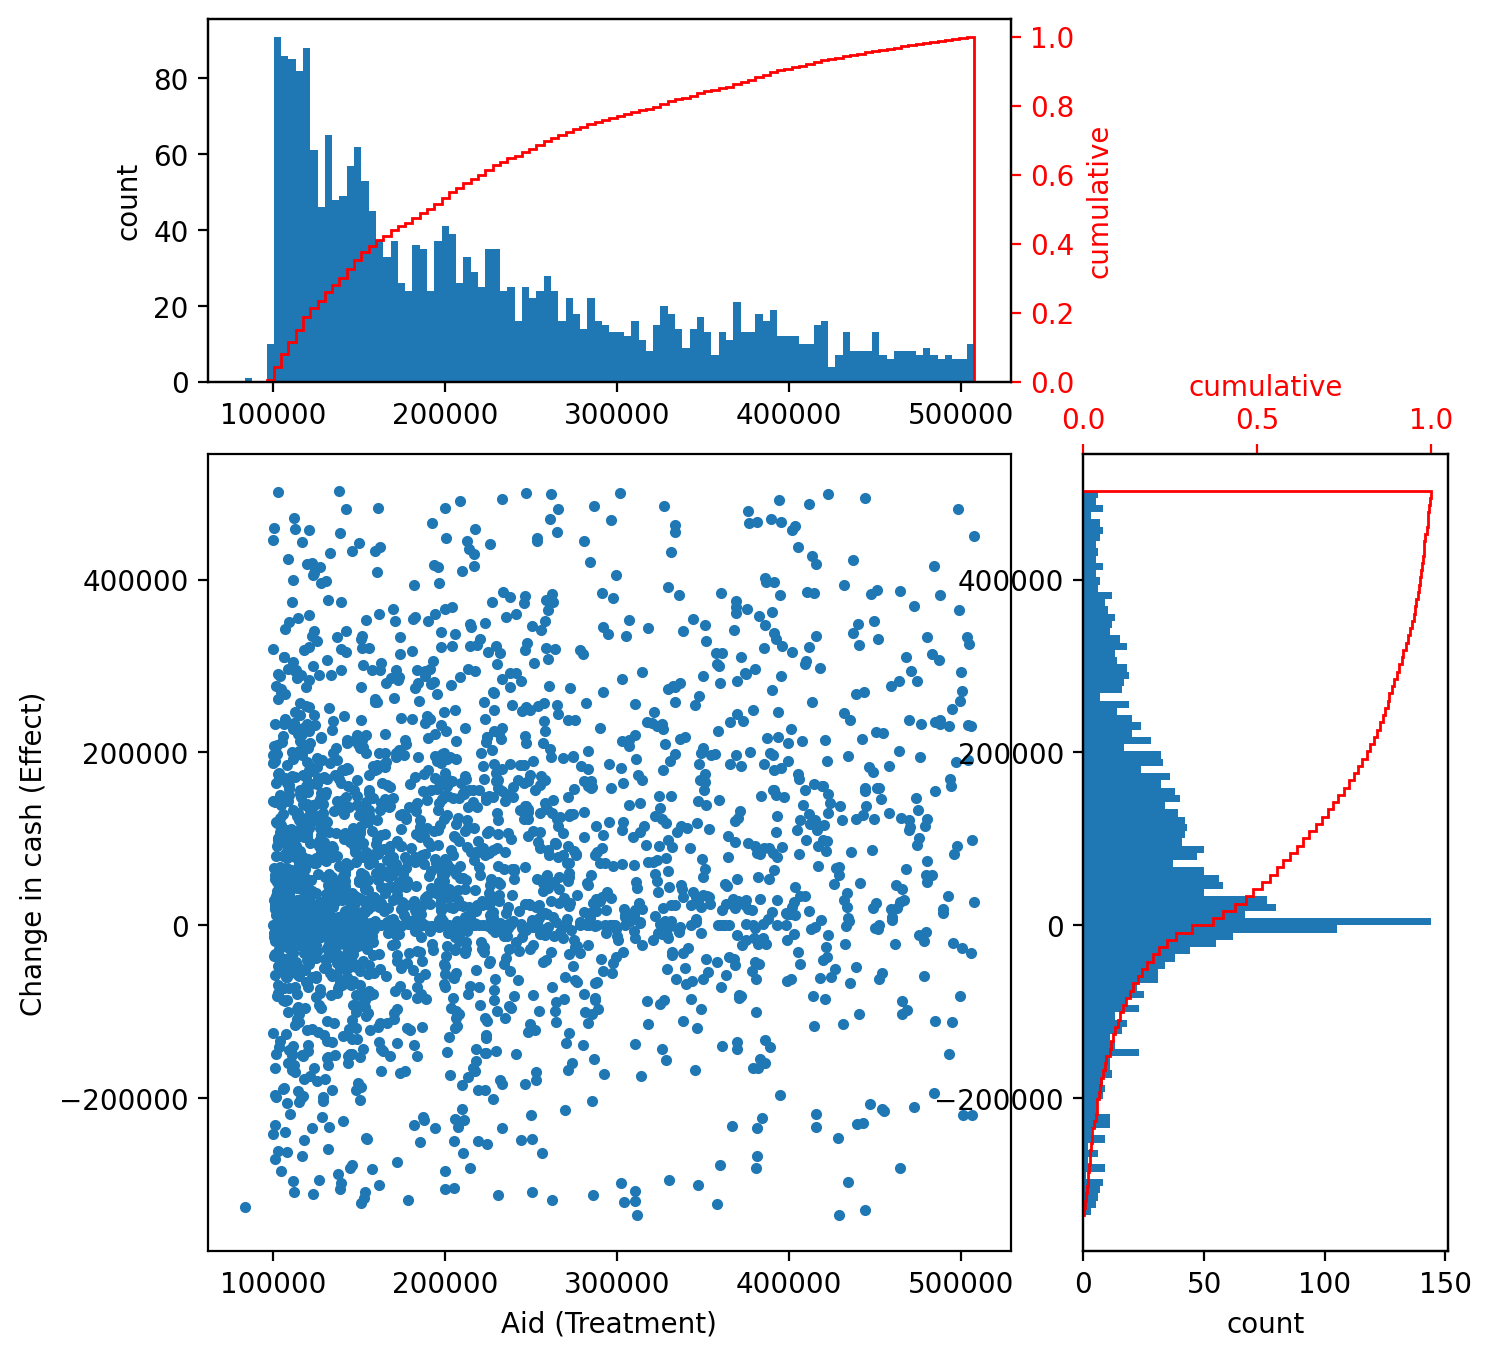

In [214]:
# https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

x = final_df[['grant_2021']]
y = final_df[['delta_cash_2021']]

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
ax_main.scatter(x,y,marker='.')
ax_main.set(xlabel="Aid (Treatment)", ylabel="Change in cash (Effect)")

ax_xDist.hist(x,bins=100,align='mid')
ax_xDist.set(ylabel='count')
ax_xCumDist = ax_xDist.twinx()
ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid')
ax_xCumDist.tick_params('y', colors='r')
ax_xCumDist.set_ylabel('cumulative',color='r')

ax_yDist.hist(y,bins=100,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count')
ax_yCumDist = ax_yDist.twiny()
ax_yCumDist.hist(y,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid',orientation='horizontal')
ax_yCumDist.tick_params('x', colors='r')
ax_yCumDist.set_xlabel('cumulative',color='r')

plt.show()

### Old

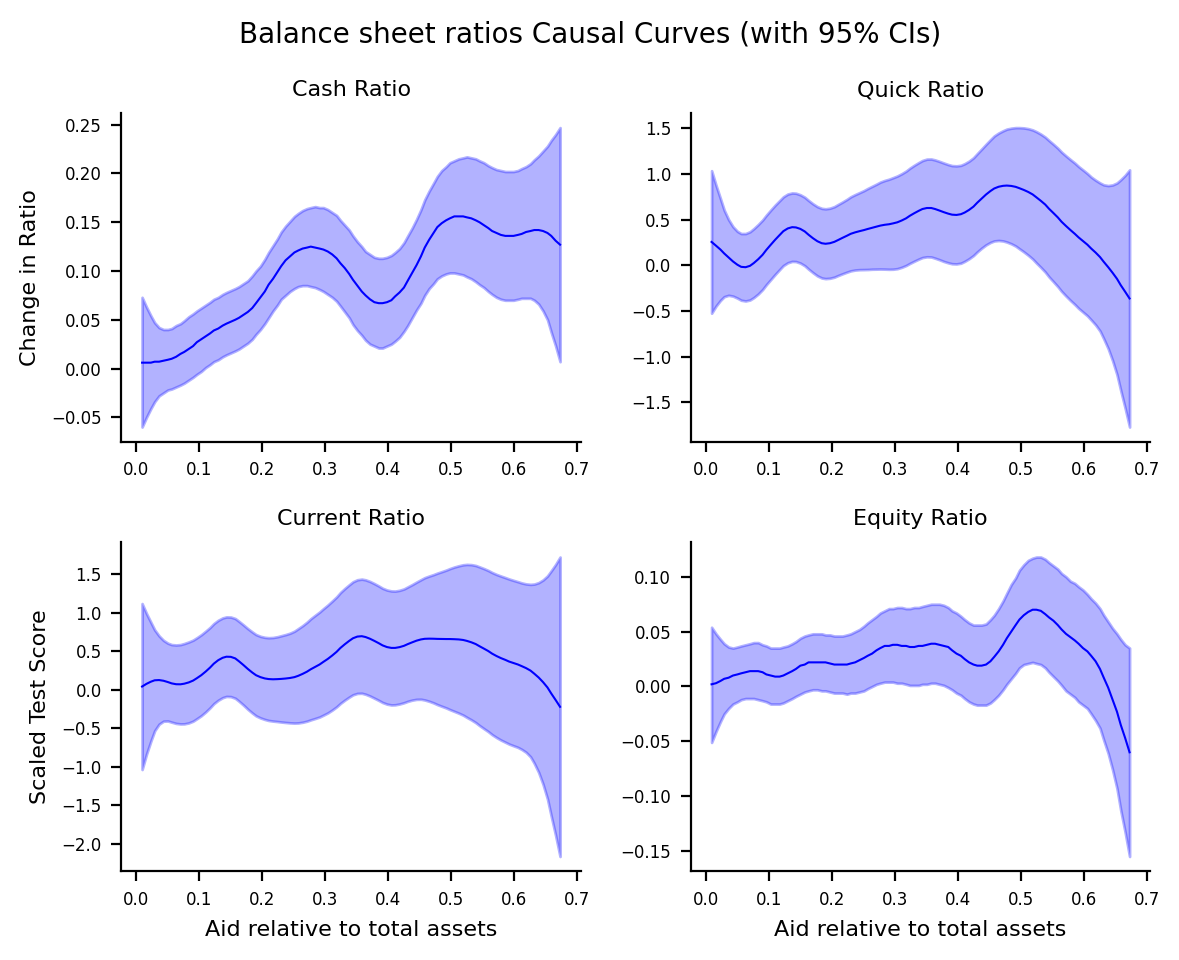

In [39]:
result_class = [['delta_cash_ratio_2021', 'delta_qick_ratio_2021'], ['delta_current_ratio_2021', 'delta_equity_ratio_2021']]

result_name = [['Cash Ratio', 'Quick Ratio'], ['Current Ratio', 'Equity Ratio']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Ratio', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 8)
        axs[1,1].set_xlabel('Aid relative to total assets', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        #axs[i,j].set_xlim(0, 2)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Balance sheet ratios Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

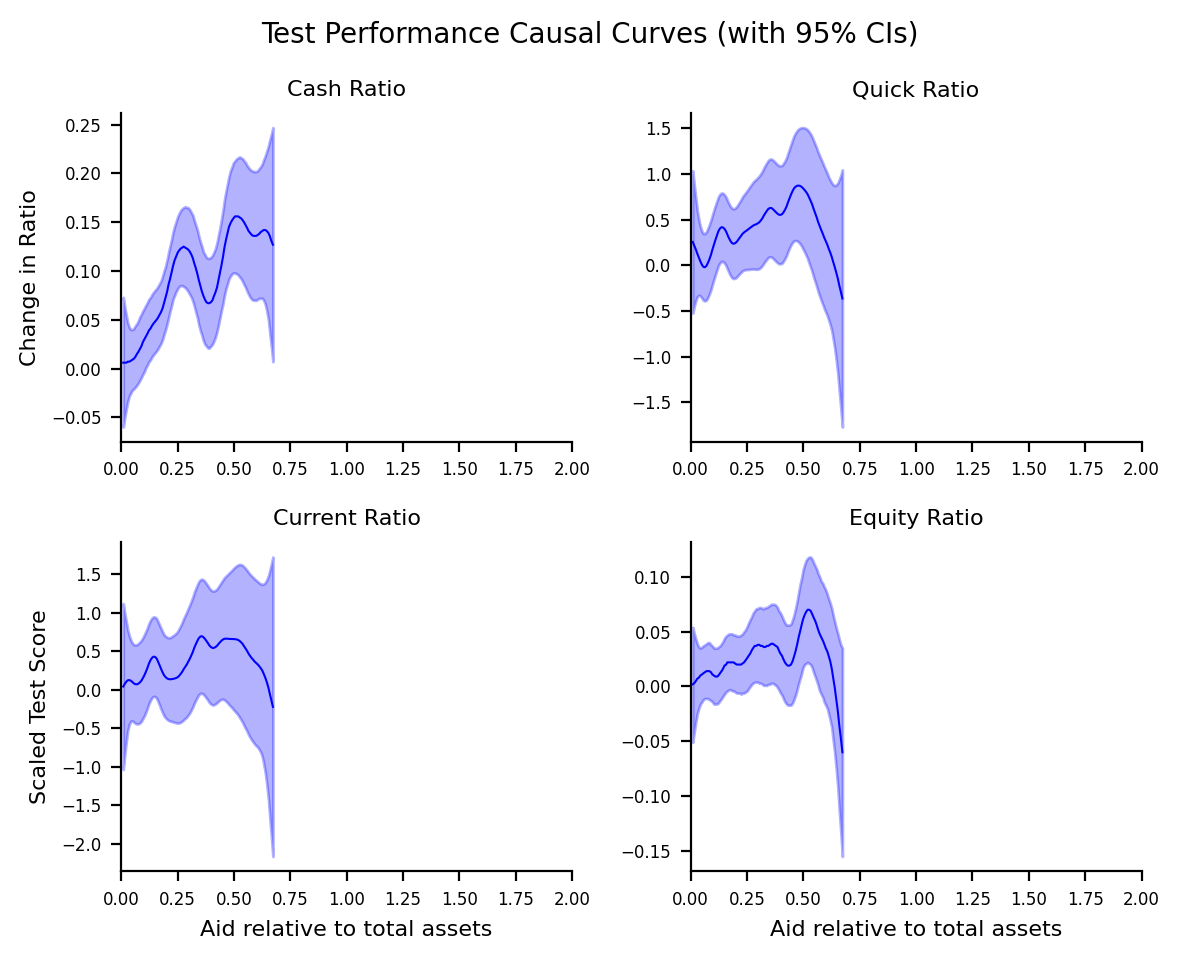

In [40]:
result_class = [['delta_cash_ratio_2021', 'delta_qick_ratio_2021'], ['delta_current_ratio_2021', 'delta_equity_ratio_2021']]

result_name = [['Cash Ratio', 'Quick Ratio'], ['Current Ratio', 'Equity Ratio']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Ratio', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 8)
        axs[1,1].set_xlabel('Aid relative to total assets', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        axs[i,j].set_xlim(0, 2)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Test Performance Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

In [41]:
# Dictionary to store model results
results_dict = {}

# Potential confounders
potential_confounders = list(condounders.columns)

# Try the MATH model
math_gps = TMLE_Regressor(random_seed=111,bandwidth=10)
#math_gps = GPS_Regressor()
math_gps.fit(
    T=final_df['aid_relative'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_ratio']
)

results_dict['qick_ratio_2021'] = math_gps.calculate_CDRC()

KeyError: 'aid_relative'

In [ ]:
results_dict['math_CDRC'] = math_gps.calculate_CDRC()
results_dict['reading_CDRC'] = math_gps.calculate_CDRC()
results_dict['block_CDRC'] = math_gps.calculate_CDRC()
results_dict['digit_CDRC'] = math_gps.calculate_CDRC()

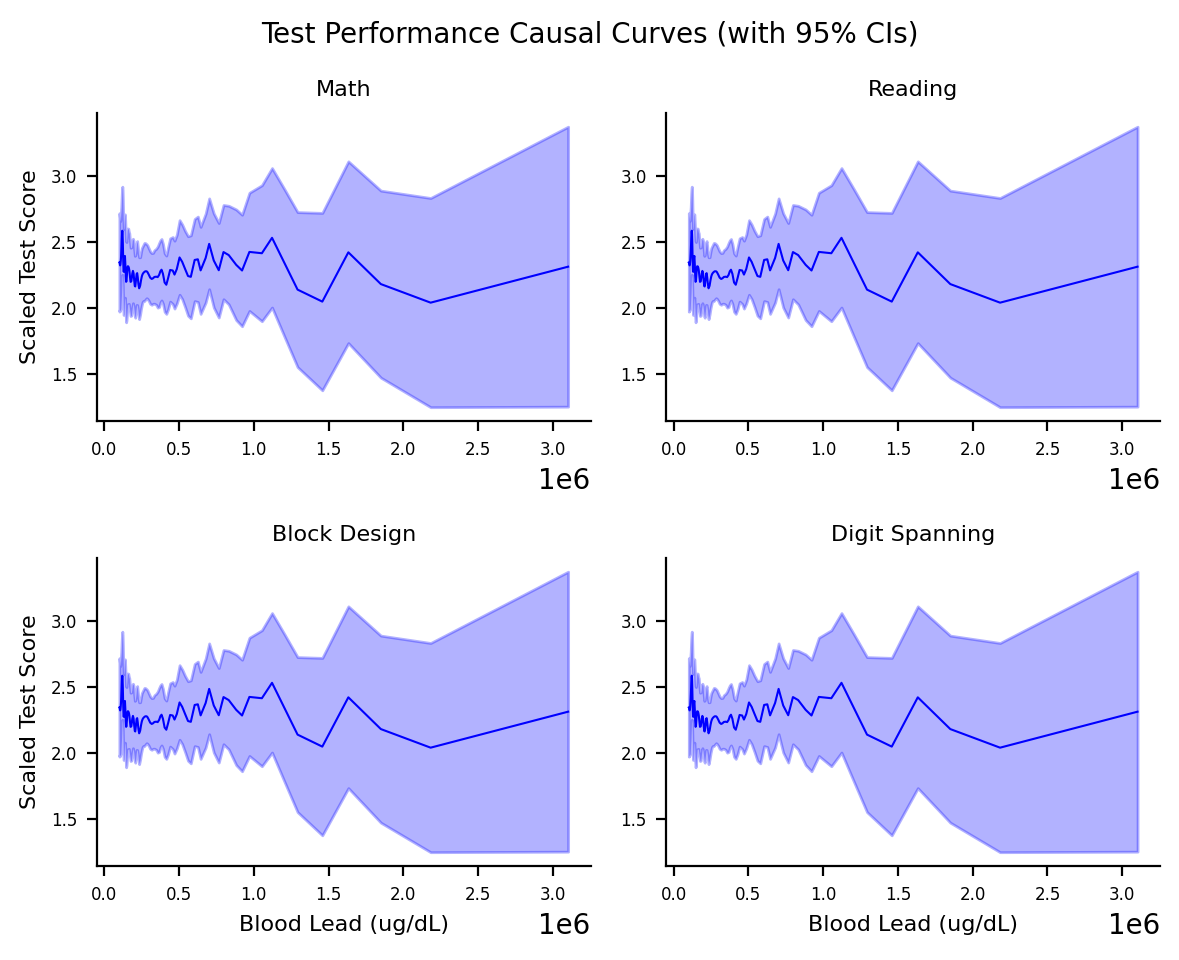

In [ ]:
result_class = [['math_CDRC', 'reading_CDRC'], ['block_CDRC', 'digit_CDRC']]

result_name = [['Math', 'Reading'], ['Block Design', 'Digit Spanning']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)
        axs[1,1].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        #axs[i,j].set_xlim(0, 10)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Test Performance Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

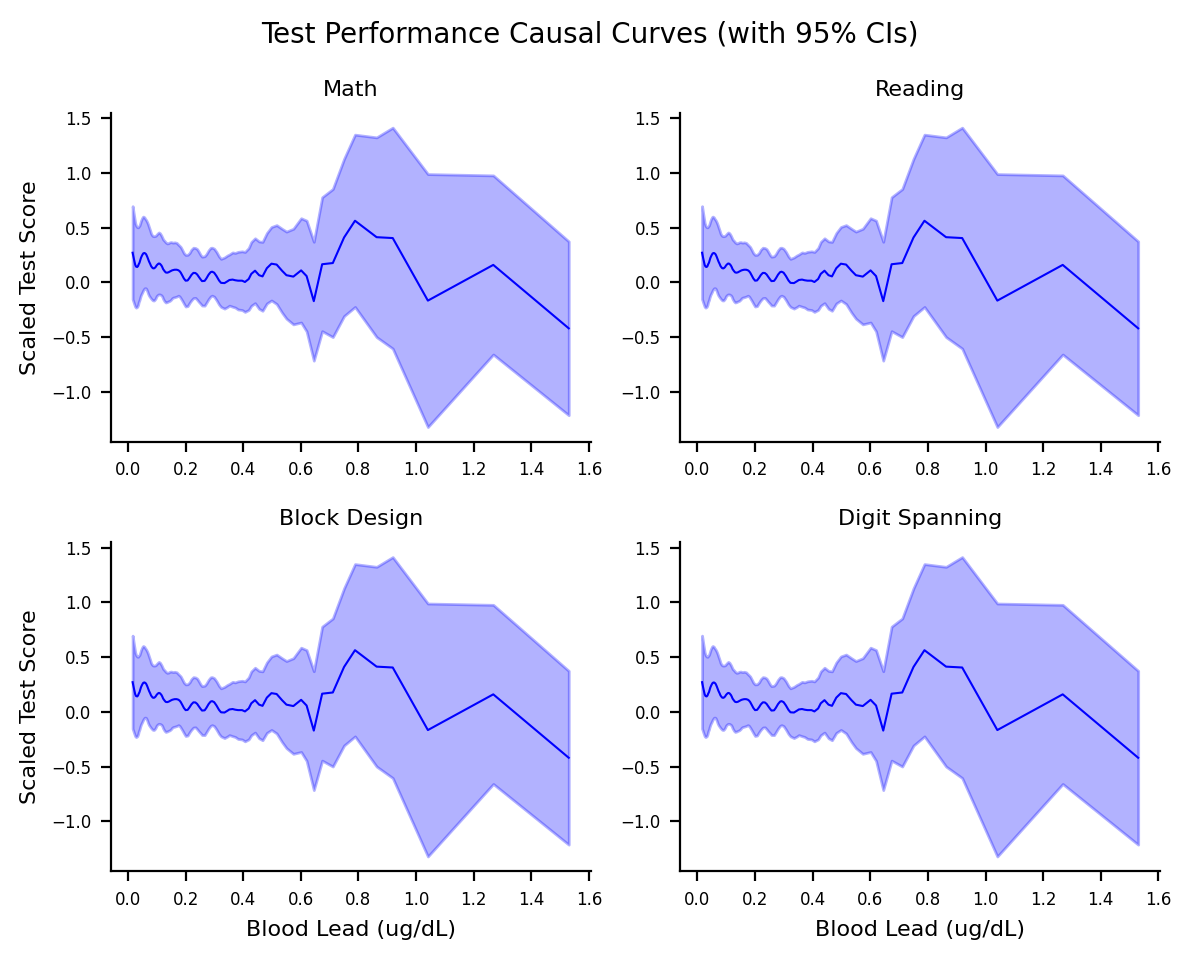

In [ ]:
result_class = [['math_CDRC', 'reading_CDRC'], ['block_CDRC', 'digit_CDRC']]

result_name = [['Math', 'Reading'], ['Block Design', 'Digit Spanning']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)
        axs[1,1].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        #axs[i,j].set_xlim(0, 10)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Test Performance Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

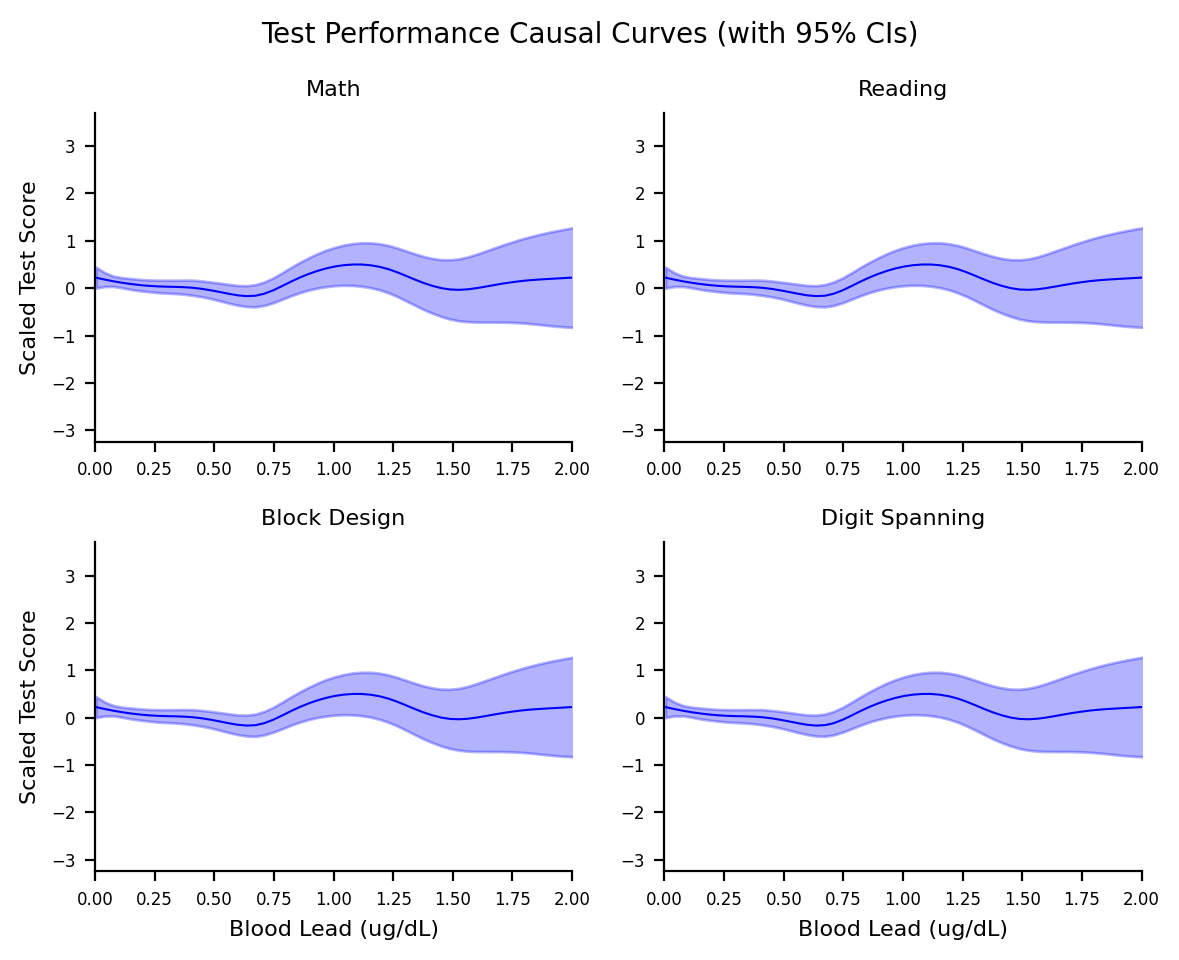

In [ ]:
result_class = [['math_CDRC', 'reading_CDRC'], ['block_CDRC', 'digit_CDRC']]

result_name = [['Math', 'Reading'], ['Block Design', 'Digit Spanning']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)
        axs[1,1].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        axs[i,j].set_xlim(0, 2)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Test Performance Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

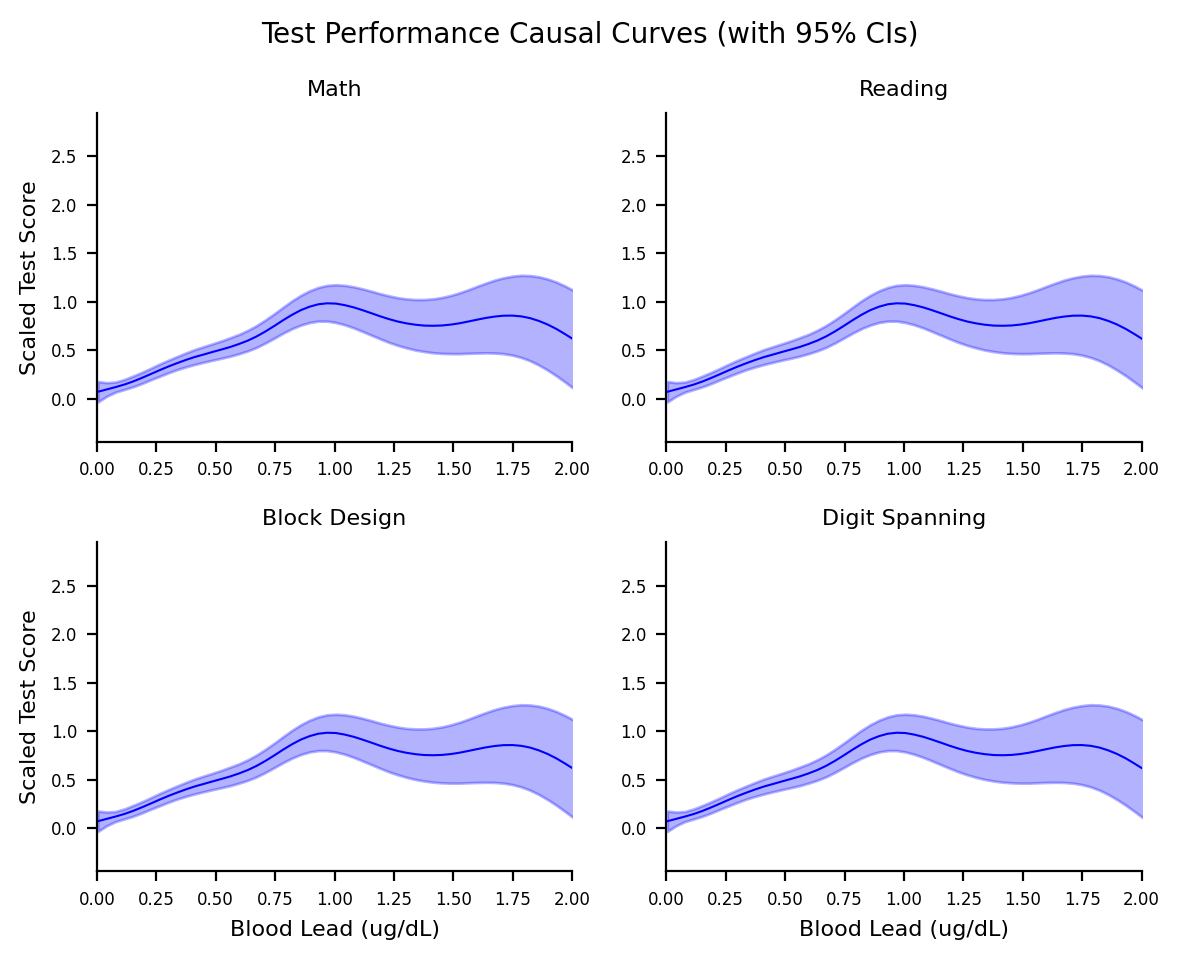

In [ ]:
result_class = [['math_CDRC', 'reading_CDRC'], ['block_CDRC', 'digit_CDRC']]

result_name = [['Math', 'Reading'], ['Block Design', 'Digit Spanning']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)
        axs[1,1].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        axs[i,j].set_xlim(0, 2)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Test Performance Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

In [ ]:
# Dictionary to store model results
results_dict = {}

# Potential confounders
potential_confounders = list(pd.get_dummies(df["industry_1"], prefix='industry', drop_first=True).columns)

# Try the MATH model
math_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)
math_gps.fit(
    T=df['BLL'], 
    X=df[potential_confounders], 
    y=df['Math']
)

results_dict['math_CDRC'] = math_gps.calculate_CDRC()


# Try the READING model
reading_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)

reading_gps.fit(
    T=df['BLL'], 
    X=df[potential_confounders],  
    y=df['Reading']
)

results_dict['reading_CDRC'] = reading_gps.calculate_CDRC()



# Try the Block model
block_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)

block_gps.fit(
    T=df['BLL'], 
    X=df[potential_confounders],  
    y=df['Block']
)

results_dict['block_CDRC'] = block_gps.calculate_CDRC()



# Try the Digit model
digit_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)

digit_gps.fit(
    T=df['BLL'], 
    X=df[potential_confounders],  
    y=df['Digit']
)

results_dict['digit_CDRC'] = digit_gps.calculate_CDRC()

In [164]:
test_df = merged_df

In [165]:
df_pivot = pd.wide_to_long(test_df, ["loan","current_ratio","current_liabilities","liabilities","qick_ratio","equity","equity_ratio","cash","assets","current_assets","cash_ratio","debt2asset_ratio","debt2equity_ratio"], i="company", j="year", sep="_")

In [166]:
df_pivot = df_pivot.reset_index()

In [167]:
df_pivot = df_pivot[df_pivot['loan'].isna()]

In [168]:
df_pivot['cohort_2020'] = np.where((~df_pivot['grant_2020'].isna()) & (df_pivot['grant_2021'].isna()) & (df_pivot['grant_2022'].isna()) ,1,0)
df_pivot['cohort_2021'] = np.where((df_pivot['grant_2020'].isna()) & (~df_pivot['grant_2021'].isna()) & (df_pivot['grant_2022'].isna()) ,2,0)
df_pivot['cohort_2022'] = np.where((df_pivot['grant_2020'].isna()) & (df_pivot['grant_2021'].isna()) &  (~df_pivot['grant_2022'].isna()),3,0)


In [169]:
df_pivot['cohort'] = df_pivot['cohort_2020']+df_pivot['cohort_2021']+df_pivot['cohort_2022']

In [148]:
df_pivot

,company,year,grant_2022,grant_2020,industry,industry_1,size,grant_2021,industry_2,grant_2023,...,cash,assets,current_assets,cash_ratio,debt2asset_ratio,debt2equity_ratio,cohort_2020,cohort_2021,cohort_2022,cohort
0,"""CEDON"" MuseumShops GmbH",2020,NaN,NaN,Sonstiger Einzelhandel in Verkaufsräumen (ohne...,Handel; Instandhaltung und Reparatur von Kraft...,nur Großunternehmen,NaN,Einzelhandel (ohne Handel mit Kraftfahrzeugen),NaN,...,356456.98,2953545.57,2494337.15,0.120688,0.656094,1.981450,0,0,0,0
1,"""Capillar GmbH""",2020,NaN,NaN,Einzelhandel (ohne Handel mit Kraftfahrzeugen),Handel; Instandhaltung und Reparatur von Kraft...,Kleine und mittlere Unternehmen,NaN,Einzelhandel (ohne Handel mit Kraftfahrzeugen),NaN,...,233693.31,2732777.71,1225767.05,0.085515,0.730747,2.820029,0,0,0,0
2,"""Der Pommeraner"" Loitz GmbH",2020,NaN,NaN,Fleischverarbeitung,Verarbeitendes Gewerbe,nur Großunternehmen,NaN,Herstellung von Nahrungs- und Futtermitteln,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,"""Die Rakete"" Gastro GmbH",2020,NaN,NaN,Ausschank von Getränken,Gastgewerbe,nur Großunternehmen,NaN,Gastronomie,NaN,...,74102.15,459210.13,320787.82,0.161369,0.778499,21.489087,0,0,0,0
4,"""ECOMA"" Maschinen GmbH",2020,NaN,NaN,Herstellung von Maschinen für sonstige bestimm...,Verarbeitendes Gewerbe,nur Großunternehmen,NaN,Maschinenbau,NaN,...,325.42,1687367.43,1187927.95,0.000193,0.976672,inf,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117910,ÜberQuell GmbH,2019,NaN,NaN,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastgewerbe,Kleine und mittlere Unternehmen,421111.0,Gastronomie,NaN,...,9972.35,1976323.34,272819.28,0.005046,0.856215,inf,0,2,0,2
117911,Überfluss Hotelbetriebsgesellschaft mbH,2019,739038.0,NaN,"Hotels, Gasthöfe und Pensionen",Gastgewerbe,Kleine und mittlere Unternehmen,1061559.0,Beherbergung,NaN,...,215332.33,713805.80,636005.80,0.301668,0.925365,13.270292,0,0,0,0
117912,Ürer Mobilfunk GmbH,2019,103358.0,NaN,Einzelhandel mit Telekommunikationsgeräten,Handel; Instandhaltung und Reparatur von Kraft...,Kleine und mittlere Unternehmen,NaN,Einzelhandel (ohne Handel mit Kraftfahrzeugen),NaN,...,96062.14,519789.45,452540.16,0.184810,0.355516,0.587380,0,0,3,3
117913,überland Reisen Berlin GmbH,2019,NaN,NaN,Reiseveranstalter,Erbringung von sonstigen wirtschaftlichen Dien...,Kleine und mittlere Unternehmen,228885.0,"Reisebüros, Reiseveranstalter und Erbringung s...",NaN,...,258708.54,370426.25,369249.25,0.698408,0.590681,1.997415,0,2,0,2
